# roslaunch stdr_launchers server_with_map_and_gui_plus_robot.launch

# Change the specification of the robot  (the angles of the sensor"pandora_robot.yaml"

In [42]:
from nav_msgs.msg import Odometry, OccupancyGrid
from geometry_msgs.msg import Twist, Point
from std_msgs.msg import Float32
from sensor_msgs.msg import LaserScan, Range
from numpy import sin, cos, pi
from numpy.linalg import norm

import matplotlib.pyplot as plt
import transformations as tf
import numpy as np

import matplotlib
import rospy
import pcl

from __future__ import print_function

In [43]:
%matplotlib inline
%matplotlib notebook

In [ ]:
        ########DEBUGGING#######
        if self.isPrint:
            print(self.transform_range_rtow(Os_))
            print(self.transform_range_rtow(Os_).shape)
            isPrint = 0
        ########################

In [45]:
class TangentBug:
    ########DEBUGGING########
    isPrint = 1
    #########################
    angles = None
    ranges = None
    angle_min = None
    angle_max = None
    angle_inc = None
    range_max = None
    
    q    = None # [x, y] numpy.array
    th   = None # theta scalar
    goal = None # [x, y] numpy.array
    
    ls_topic_name   = "/robot0/laser_0"
    odom_topic_name = "/robot0/odom"
    goal_topic_name = "/robot0/goal"
    last_ls_msg = LaserScan()
    def __init__(self):
        # Subscribers
        rospy.Subscriber(  self.ls_topic_name, LaserScan,   self.lsCB)
        rospy.Subscriber(self.odom_topic_name,  Odometry, self.odomCB)
        rospy.Subscriber(self.goal_topic_name,     Point, self.goalCB)
        # Set some initial values
        rospy.loginfo("Waiting for laserscan msg to arrive")
        rospy.wait_for_message(  self.ls_topic_name, LaserScan)
        rospy.loginfo("Waiting for odometry msg to arrive")
        rospy.wait_for_message(self.odom_topic_name,  Odometry)
        self.angle_min = self.last_ls_msg.angle_min
        self.angle_max = self.last_ls_msg.angle_max
        self.angle_inc = self.last_ls_msg.angle_increment
        self.range_max = self.last_ls_msg.range_max
        self.goal = np.array([5., 
                              5.])
        #np.arange(self.angle_min, self.angle_max + self.angle_inc, self.angle_inc)
        self.angles    = np.linspace(self.angle_min, self.angle_max, 667) # 667 from robot specification
        
        # Publishers
        self.VelPub = rospy.Publisher("/robot0/cmd_vel", Twist, queue_size=10)
        self.DThPub = rospy.Publisher("/robot0/theta_d", Float32, queue_size=10)
        
        #TODO
        rospy.loginfo("Tangent Bug Initialized")
    # LaserScan Callback
    def lsCB(self, msg):
        """
        Will 1- set the last_ls_msg to the current msg
             2- get the new ranges values
        @param msg: message
        @type sensor_msgs.msg.LaserScan
        """
        self.last_ls_msg = msg
        if self.angles is not None:
            ranges_np   = self.laserscan_to_numpy(msg)
            idx         = np.where(ranges_np != np.inf)[0] # the index zero is becasue np.where returns a tuple (.,)
            self.ranges = self.transform_range_stor(ranges_np[idx], self.angles[idx])
            self.ranges = self.transform_range_rtow(self.ranges)
    def odomCB(self, msg):
        """
        Get the new robot position and angles
        """
        self.q  = np.array([msg.pose.pose.position.x, 
                            msg.pose.pose.position.y])
        
        self.th = tf.euler_from_quaternion([msg.pose.pose.orientation.x,
                                            msg.pose.pose.orientation.y, 
                                            msg.pose.pose.orientation.z, 
                                            msg.pose.pose.orientation.w])[-1] # only z component
    def goalCB(self, msg):
        self.goal  = np.array([msg.x, 
                               msg.y])
    #@staticmethod
    def transform_range_stor(self, x, angles):
        """
        transform the values from sensor frame to robot frame
        @param  x :vals_wrt_sensor 
        @type   list len(x) == #pts
        @param  angles: 
        @type   list len(angles) = #pts
        @return the sensor values wrt robot frame
        @rtype  numpy.ndarray (#pts, 2)
        """
        vals_wrt_robot = map(lambda angle, z: list(np.dot(self.Rz(angle), [z, 0])), angles, x)
        return np.array(vals_wrt_robot)
    def transform_range_rtow(self, data):
        """
        transform the values from sensor frame to robot frame
        @param  x :vals_wrt_sensor LaserScan msg
        @type   sensor_msgs.msg.LaserScan
        @return the sensor values wrt robot frame
        @rtype  numpy.ndarray (#pts, 2)
        """
        T = self.Twr(self.th, self.q)
        vals_wrt_world = map(lambda pt: list(np.dot(T, [pt[0], pt[1], 1])), data)
        return np.array(vals_wrt_world)[:, :-1] # the last column is all 1's
    def get_heading_pt(self, step_size=0.01, T_inf=True):
        """
        @param step_size
        @type  scalar
        @param T_inf
        @type
        @return The heading point
        @rtype numpy.array (2, )
        """
        x         = np.copy(self.q)
        goal      = self.goal
        pts       = self.ranges       
        range_max = self.range_max
        pt        = x
        direction = (goal - x) / norm(goal - x)
        dx        = direction * step_size
        num_steps = int(range_max / step_size)
        for i in range(num_steps):
            if self.check_colision(pt, pts) == True:
                if T_inf == True:
                    return np.array([np.inf, np.inf])
                return pt
            pt += dx
        return pt
    #TODO change name to get_endpts
    def get_endpoints(self):
        """
        @return the [x, y] of each endpoints
        @rtype  numpy.array (# endpoints, 2)
        """
        Z = self.laserscan_to_numpy(self.last_ls_msg)
        Z[Z == np.inf] = 100 # any big number that is bigger than self.range_max
        Oindx = np.where(np.abs(np.diff(Z)) > 0.3)[0] # Z[n + 1] - Z[n]
        Os     = []
        Angles = []
        for O in Oindx:
            Os.append(Z[O])
            Angles.append(self.angles[O])
            Os.append(Z[O + 1])
            Angles.append(self.angles[O + 1])
        infIdx = np.where(np.array(Os) != 100.)[0]
        Os_ = self.transform_range_stor(np.array(Os)[infIdx], np.array(Angles)[infIdx])
        return self.transform_range_rtow(Os_)
    @staticmethod
    def check_colision(x, pts, eps=0.025):
        """
        Check if any of the pts are in inside a ball with eps radius centered at x
        """
        if np.any(norm(x - pts, axis=-1) < eps):
            return True
        return False
    @staticmethod
    def get_normal(pts):
        """
        @param pts: points to calculate normal to their least sqaure error minimizer line
        @type numpy.ndarray
        @return the coefficient of line b + a * x (a = coef[1], b = coef[0])
        @rtype numpy.ndarray
        """
        X = np.c_[np.ones((pts.shape[0],)), pts[:, 0]] # [1, x][b, a]T
        y = pts[:, 1]
        coef = np.dot(np.linalg.pinv(X), y)
        norm = np.array([coef[1], -1]) # normal to ax - y + b = 0 is <a, -1>
        norm /= np.linalg.norm(norm)   # return the unit vector normal
        """
        to test is acutally a normal
        tangentVec = np.array([2 - 1, coef[1] * (2 - 1)])
        tangentVec /= np.linalg.norm(tangentVec)
        np.dot(pts[0,:] - pts[2,:], norm) should be ~= 0
        np.dot(tangentVec, norm) == 0
        """
        return norm
    @staticmethod
    def h_fn(x, goal, pts):
        """
        heuristic function
        """
        return norm(x - pts, axis=-1) + norm(pts - goal, axis=-1) 
    #@staticmethod
    def get_pt_minimize(self, pts, hf=None):
        """
        @return point that minimize the heuristic function
        @rtype np.array (2, )
        """
        if hf == None:
            hf = self.h_fn
        x = np.copy(self.q)
        goal = np.copy(self.goal)
        idx = np.argmin(hf(x, goal, pts))
        return pts[idx]
    #TODO change name to discard_endpts
    def discard_Oi(self, Oi):
        x    = self.q
        goal = self.goal 
        idx = norm(Oi - goal, axis=-1) < norm(x - goal, axis=-1)
        return Oi[idx]
    @staticmethod
    def laserscan_to_numpy(ls):
        """
        @param  ls: LaserScan msg
        @type   sensor_msgs.msg.LaserScan
        @return the numpy version of the range values of the sensor
        @rtype  numpy.ndarray
        """
        vals = np.array(list(ls.ranges))
        return vals
    @staticmethod
    def Rz(angle):
        """
        2x2 rotaton matrix about z-axis
        @param  angle in radians
        @type   int
        @return 2x2 rotation matrix about the z axis
        @rtype  numpy.ndarray
        """
        return tf.euler_matrix(0, 0, angle)[:2, :2]
    @staticmethod
    def Twr(angle, q):
        """
        1- translational 2- rotational
        @param  angle: 
        @type   integer
        @param  pos:
        @type   numpy.ndarray
        @return 3x3 homogeneous transformation matrix
        @rtype  numpy.ndarray
        """
        T         = np.dot(tf.translation_matrix([q[0], q[1], 0.]), tf.euler_matrix(0, 0, angle))[:3, :3]
        T[:2, -1] = np.dot(tf.translation_matrix([q[0], q[1], 0.]), tf.euler_matrix(0, 0, angle))[:2, -1]
        return T
    @staticmethod
    def get_pts(vals, idx, num_pts = 1):
        """
        @param  vals [x, y] coordinates of the sensor
        @type   numpy.ndarray
        @param  idx index of the points to return the symmetric points(num_pts) around it
        @type   int
        @param  num_pts number of points to return the value around idx
        @type   int
        @return [x, y] coordinates of the points within idx - num_pts and idx + num_pts + 1
        @rtype  numpy.ndarray
        """
        lower_bound = 0              if (idx - num_pts) < 0                   else (idx - num_pts) 
        upper_bound = vals.shape[-1] if (idx + num_pts + 1) >= vals.shape[-1] else (idx + num_pts + 1)
        pts = vals[lower_bound:upper_bound, :]
        return pts
    @staticmethod
    def conca_pts(Os, T):
        """
        concatenate the endpoints and T
        """
        return np.r_[Os, [list(T)]]
    def get_abs_angle_to_pt(self, x1):
        """
        the angle of the vector x2 - x1
        the vector the pointing from x1 to x2
        get_angle(q, goal)
        """
        x = x1 - self.q
        return np.arctan2(x[1], x[0])
    def impl(self):
        th_d_msg = Float32()
        goal = np.copy(self.goal)
        q    = np.copy(self.q)
        T  = self.get_heading_pt(T_inf=False)
        Oi = self.get_endpoints()
        Oi = self.discard_Oi(Oi)
        T_Oi = self.conca_pts(Oi, T)
        head_pt = self.get_pt_minimize(T_Oi)
        th_d = self.get_abs_angle_to_pt(head_pt)
        th_d_msg.data = th_d
        self.DThPub.publish(th_d_msg)
        return head_pt

In [46]:
rospy.init_node("TangentBug")
bug = TangentBug()

[INFO] [1537625001.814191]: Waiting for laserscan msg to arrive
[INFO] [1537625001.954082]: Waiting for odometry msg to arrive
[INFO] [1537625002.088787]: Tangent Bug Initialized


In [48]:
bug.impl()

array([ 2.616,  3.212])

[WARN] [1537625623.320499]: Inbound TCP/IP connection failed: connection from sender terminated before handshake header received. 0 bytes were received. Please check sender for additional details.


In [20]:
T = bug.get_heading_pt()
Os = bug.get_endpoints()
#print(Os)
Os = bug.discard_Oi(Os)
h_pt =  bug.get_n_minimize(buself.h_fng.q, bug.goal, bug.conca_T_Oi(Os, T), bug.heuristic_fn) # heading point
th_d = bug.abs_angle_to_pt(h_pt)
print(T, h_pt, th_d - bug.th)

[[ 2.55915629  5.77033567]
 [ 1.74176357  3.61808118]
 [ 2.71614125  2.60601895]
 [ 4.95718333  1.85067325]
 [ 4.77176862  1.75067842]
 [ 3.08515079  1.43631079]]
(6, 2)
[inf, inf] [ 2.71614125  2.60601895] 0.3394594708


<IPython.core.display.Javascript object>


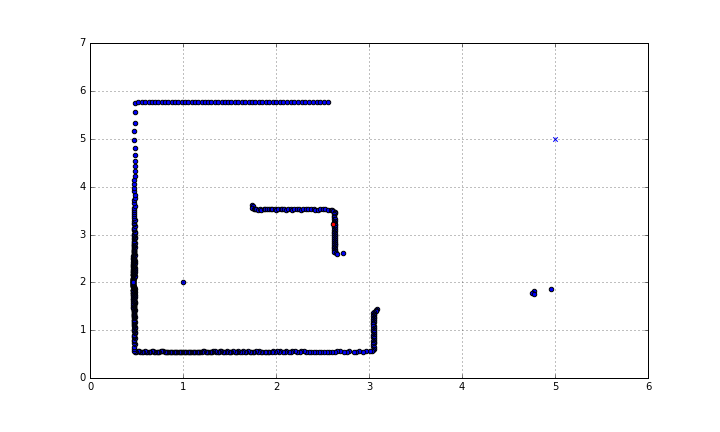

In [39]:
matplotlib.rcParams["figure.figsize"] = (10, 6)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
#ax.set_xticks(np.linspace(0., 6., 25))
#ax.set_xticks(minor_ticks, minor=True)
#ax.set_yticks(np.linspace(0., 6., 25))
#ax.set_yticks(minor_ticks, minor=True)
#plt.xlim((0, 6.))
#plt.ylim((0, 6.))
#plt.grid(True)
ax.grid(which='both')
ax.scatter(bug.ranges[:,0], bug.ranges[:, 1])
#ax.scatter(ranges[:,0], ranges[:, 1])
#ax.scatter(T[0], T[1], c='r')
#ax.scatter(Os[:, 0], Os[:, 1], c='r')
#ax.scatter(mins[0], mins[1], c=[1., 1., 0., 1.])
ax.scatter(bug.goal[0], bug.goal[1], marker='x')
ax.scatter(bug.q[0], bug.q[1], marker='o')
ax.scatter(bug.impl()[0], bug.impl()[1], c='r')
#ax.scatter(np.r_[ranges[Os], [list(T)]][:, 0], np.r_[ranges[Os], [list(T)]][:, 1], c='r')